In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc,recall_score,precision_score
import sys, os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import math

In [11]:
#https://github.com/dhaitz/mplcyberpunk
import mplcyberpunk

Note: you may need to restart the kernel to use updated packages.


In [3]:
sys.path.append(os.path.realpath('..'))

In [28]:
train_df = pd.read_csv(r"..\data\train.csv", index_col=0)
test_df = pd.read_csv(r"..\data\test.csv", index_col=0)
xgb_train_df = pd.read_csv(r'rendered_data/XGB_train_submission.csv', index_col=0)
lgbm_train_df = pd.read_csv(r'rendered_data/LGBM_train_submission.csv', index_col=0)
cat_train_df = pd.read_csv(r'rendered_data/CAT_train_submission.csv', index_col=0)

xgb_test_df = pd.read_csv(r'rendered_data/XGB_test_submission.csv', index_col=0)
lgbm_test_df = pd.read_csv(r'rendered_data/LGBM_test_submission.csv', index_col=0)
cat_test_df = pd.read_csv(r'rendered_data/CAT_test_submission.csv', index_col=0)

In [29]:
features = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'gender_v', 'ever_married_v', 'work_type_v', 'Residence_type_v', 'smoking_status_v']
target = ['stroke']

In [30]:
columns_to_vectorize = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
for vector_target in columns_to_vectorize:
    vectorizer = CountVectorizer()
    vectorizer.fit_transform(train_df[vector_target])
    train_df[f'{vector_target}_v'] = vectorizer.transform(train_df[vector_target]).toarray().argmax(axis=1)[:,None]
    vectorizer.fit_transform(test_df[vector_target])
    test_df[f'{vector_target}_v'] = vectorizer.transform(test_df[vector_target]).toarray().argmax(axis=1)[:,None]

In [21]:
def roc_auc_score(y_valid, preds):
    fpr, tpr, _ = roc_curve(y_valid, preds)
    roc_auc = auc(fpr, tpr)
    return roc_auc

In [22]:
combos = []

for x in range(100):
    for y in range(100):
        if x + y < 100:
            z = 100 - x - y
            combos.append([x, y, z])
combos = np.array(combos) * ([[0.01]*3]*len(combos))
len(combos)

5050

In [23]:
coefficients = combos
best_score = 0
best_coefficients_index = 0

for index, (a, b, c) in tqdm(enumerate(coefficients)):
    score = roc_auc_score(train_df["stroke"], (a * xgb_train_df['stroke']) + (b * lgbm_train_df['stroke']) + (c * cat_train_df['stroke']))
    if score > best_score:
        best_score = score
        best_coefficients_index = index

5050it [00:09, 539.84it/s]


In [24]:
coef = combos[best_coefficients_index]
blended_test_results = xgb_test_df['stroke']*coef[0] + lgbm_test_df['stroke']*coef[1] + cat_test_df['stroke']*coef[2]
final_blended_test_submission = pd.DataFrame(data={'id': test_df.index, 'stroke': blended_test_results})
final_blended_test_submission.to_csv(fr'rendered_data/final_blended_test_submission.csv', index=False)

In [31]:
from itertools import islice, cycle

plt.style.use("cyberpunk")

def add_secondary_plot(df, column, target_column, ax, n_bins, color=3, show_yticks=False, marker="."):
    secondary_ax = ax.twinx()
    bins = pd.cut(df[column], bins=n_bins)
    bins = pd.IntervalIndex(bins)
    bins = (bins.left + bins.right) / 2
    target = df.groupby(bins)[target_column].mean()
    target.plot(
        ax=secondary_ax, linestyle='',
        marker=marker, color=color, label=f"Mean '{target_column}'"
    )
    secondary_ax.grid(visible=False)
    
    if not show_yticks:
        secondary_ax.get_yaxis().set_ticks([])
        
    return secondary_ax

def render_feature_distros(train_df, test_df, features=[], labels=[], n_bins=50, n_cols=4, pad=2, h_pad=4, w_pad=None):
    histplot_hyperparams = {
        'kde':True,
        'alpha':0.4,
        'stat':'percent',
        'bins':n_bins
    }
    markers = ['.', '+', 'x', '1', '2']
    
    n_rows = math.ceil(len(features) / n_cols)
    cell_with_dim = 4
    cell_height_dim = 3
    
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * cell_with_dim, n_rows * cell_height_dim))
    plt.tight_layout(pad=pad, h_pad=h_pad, w_pad=w_pad, rect=None)
    
    # delete exess subplots
    for a in ax[n_rows - 1, int(((n_rows - (len(features) / n_cols)) * n_cols*-1)):]:
        a.axis('off')
        
    leg_handles = []
    leg_labels = []
    
    axs = []

    for i, feature in enumerate(features):
        row = math.ceil(i / n_cols) - 1
        col = (i % n_cols)
        
        color_cycle = islice(mplcyberpunk.cyberpunk_stylesheets['cyberpunk']['axes.prop_cycle'], 0, None)
        
        sns.histplot(train_df[feature], label='Train X', ax=ax[row, col], color=next(color_cycle)['color'], **histplot_hyperparams)
        sns.histplot(test_df[feature], label='Test X', ax=ax[row, col],color=next(color_cycle)['color'], **histplot_hyperparams)
        ax[row, col].set_title(f'{feature} Distribution')
        mplcyberpunk.make_lines_glow(ax[row, col])
        axs.append(ax[row, col].get_legend_handles_labels())

        for j, label in enumerate(labels):
            sub_ax = add_secondary_plot(train_df, feature, label, ax[row, col], n_bins, color=next(color_cycle)['color'], marker=markers[j])
            axs.append(sub_ax.get_legend_handles_labels())
        
    for axis in axs:
        if axis[1][0] not in leg_labels:
            leg_labels.extend(axis[1])
            leg_handles.extend(axis[0])
        
    fig.legend(leg_handles, leg_labels, loc='upper center', bbox_to_anchor=(0.5, 1.04), fontsize=14, ncol=len(features) + 2)

In [32]:
train_df['XGB_stroke'] = xgb_train_df['stroke']
train_df['LGBM_stroke'] = lgbm_train_df['stroke']
train_df['CAT_stroke'] = cat_train_df['stroke']

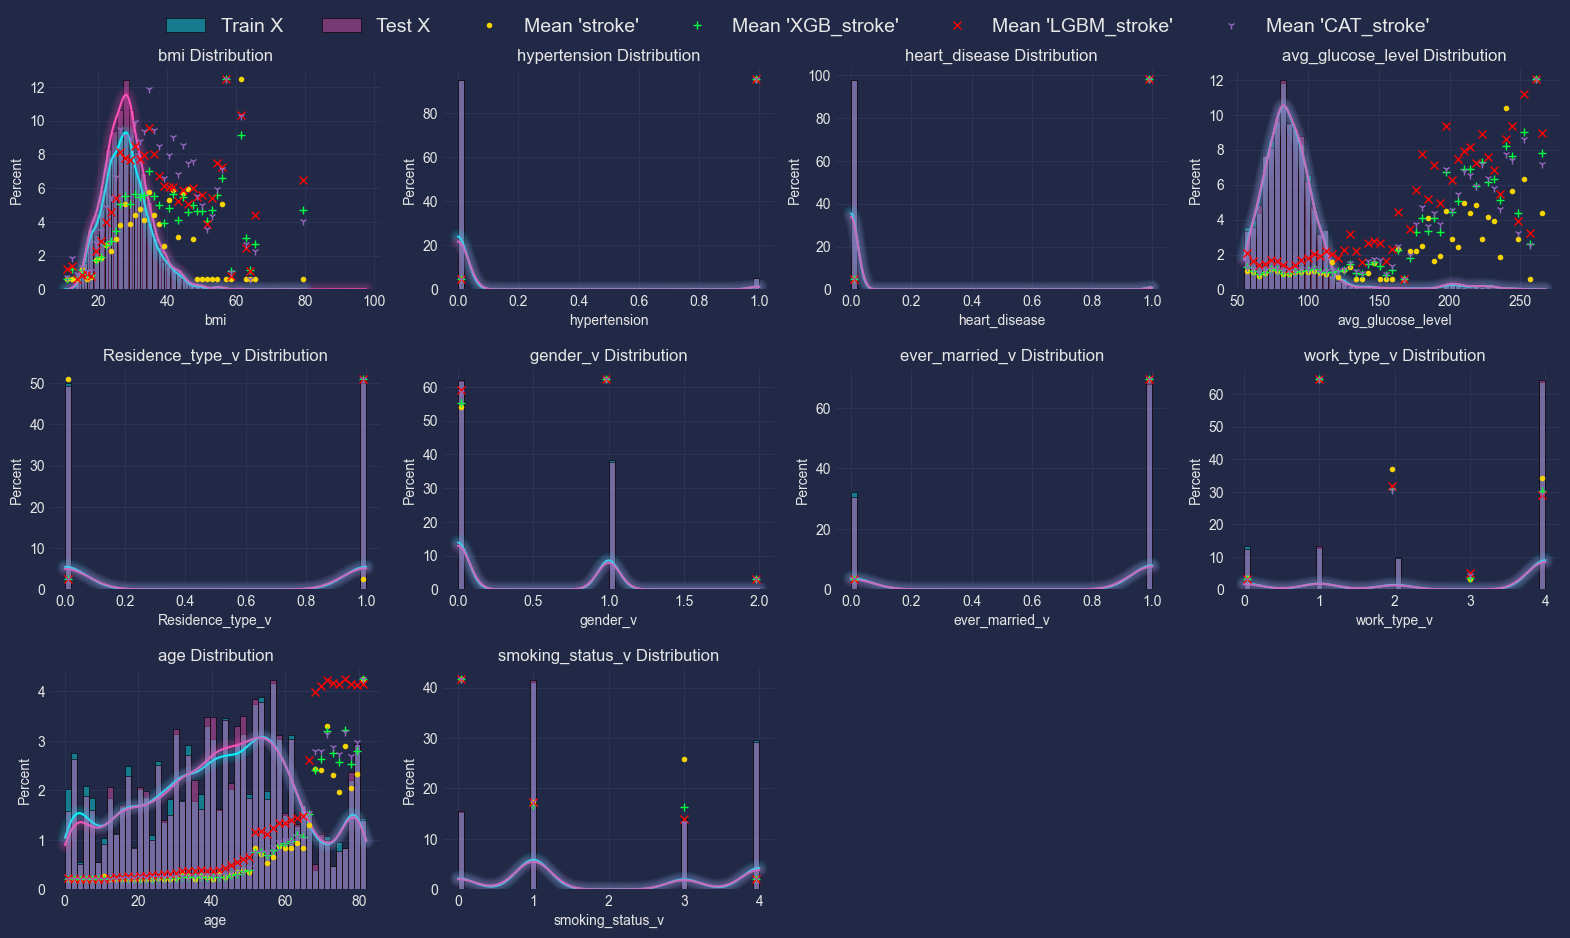

In [33]:
render_feature_distros(train_df=train_df, test_df=test_df, features=features, labels=['stroke', 'XGB_stroke', 'LGBM_stroke', 'CAT_stroke'])